In [1]:
pip install --upgrade scikit-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 10.2 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.5.0
    Uninstalling scikit-learn-1.5.0:
      Successfully uninstalled scikit-learn-1.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
islp 0.3.22 requires numpy<1.25,>=1.7.1, but you have numpy 1.26.4 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
from matplotlib import image
from sklearn.metrics import confusion_matrix

import seaborn as sns

import librosa
import librosa.display
from tensorflow.keras.models import load_model

import os

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelBinarizer, LabelEncoder
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf


from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, Embedding, LSTM, SimpleRNN
from keras.applications import imagenet_utils
from keras.applications.imagenet_utils import preprocess_input
from keras.datasets import imdb

from scipy.sparse import csr_matrix


In [3]:

f = h5py.File('spectrograms.h5', 'r')
list(f.keys())



['amecro',
 'barswa',
 'bkcchi',
 'blujay',
 'daejun',
 'houfin',
 'mallar3',
 'norfli',
 'rewbla',
 'stejay',
 'wesmea',
 'whcspa']

In [4]:

# Load spectrogram data from HDF5 file
with h5py.File('spectrograms.h5', 'r') as f:
    bluejay_data = np.array(f['blujay'])
    stejay_data = np.array(f['stejay'])
bluejay_data.shape

    

(256, 343, 50)

In [5]:
stejay_data.shape

(256, 343, 40)

In [6]:
# Create labels for bluejay (0) and stejay (1)
bluejay_labels = np.zeros(bluejay_data.shape[0])
stejay_labels = np.ones(stejay_data.shape[0])


In [7]:
import h5py
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Load the data
def load_and_preprocess_data(hdf5_file, target_species):
    features = []
    labels = []
    
    # Assign each species a unique label
    species_keys = target_species
    species_labels = {species: idx for idx, species in enumerate(species_keys)}
    
    # Populate the features and labels with data from the target species
    for species, label in species_labels.items():
        data_species = hdf5_file[species][:]
        features.extend([data_species[:, :, i] for i in range(data_species.shape[2])])
        labels.extend([label] * data_species.shape[2])
    
    # Convert features and labels to numpy arrays
    features = np.array(features)
    labels = np.array(labels)
    
    # Normalize the features
    features = features / np.max(features)
    
    # Reshape features to add the channel dimension (e.g., grayscale images have 1 channel)
    features = features[..., np.newaxis]
    
    return features, labels, species_labels

# Define the target species for binary classification
target_species = ['blujay', 'stejay']

# Load and preprocess the data
with h5py.File('spectrograms.h5', 'r') as f:
    features, labels, species_labels = load_and_preprocess_data(f, target_species)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=123)

# Convert labels to one-hot encoding
y_train_one_hot = to_categorical(y_train, num_classes=len(species_labels))
y_test_one_hot = to_categorical(y_test, num_classes=len(species_labels))

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train_one_hot.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test_one_hot.shape)

# Define CNN model for binary classification
model_binary = Sequential([
    Input(shape=(256, 343, 1)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')  # Using sigmoid activation for binary classification
])

# Compile and train the model
model_binary.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
callbacks = [EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)]
history = model_binary.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1, callbacks=callbacks)

# Evaluate the model
test_loss, test_accuracy = model_binary.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')
train_loss, train_accuracy = model_binary.evaluate(X_train, y_train)
print(f'Train Loss: {train_loss}, Train Accuracy: {train_accuracy}')


X_train shape: (63, 256, 343, 1)
y_train shape: (63, 2)
X_test shape: (27, 256, 343, 1)
y_test shape: (27, 2)
Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 821ms/step - accuracy: 0.6503 - loss: 0.6594 - val_accuracy: 0.4286 - val_loss: 2.1100
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 687ms/step - accuracy: 0.6726 - loss: 0.5719 - val_accuracy: 0.5714 - val_loss: 1.2703
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 645ms/step - accuracy: 0.8750 - loss: 0.3108 - val_accuracy: 0.5714 - val_loss: 2.7297
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 646ms/step - accuracy: 0.9330 - loss: 0.1986 - val_accuracy: 0.5714 - val_loss: 4.6664
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 708ms/step - accuracy: 0.9658 - loss: 0.1365 - val_accuracy: 0.5714 - val_loss: 5.7065
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 641ms/step - accuracy: 0.9554 - loss: 0.1057 - val_accuracy: 0.5714 - val_loss: 6.9254
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 652ms/step - accuracy: 0.9658 - loss: 0.0734 - val_accuracy: 0.5714 - val_loss: 7.4455
1/1 ━━━━

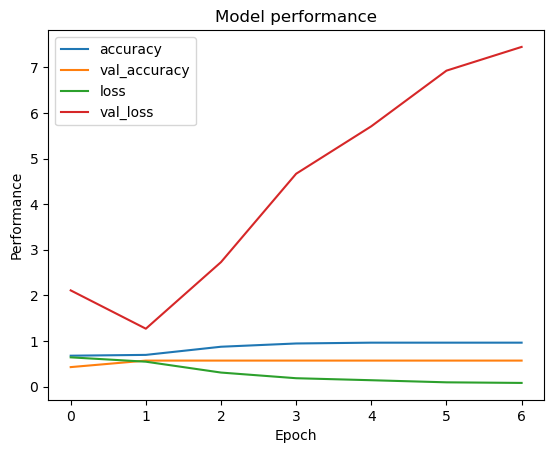

In [8]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model performance')
plt.xlabel('Epoch')
plt.ylabel('Performance')
plt.legend()
plt.show()

## Model with dropout

Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 798ms/step - accuracy: 0.4241 - loss: 0.6979 - val_accuracy: 0.5714 - val_loss: 0.7640
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 690ms/step - accuracy: 0.7500 - loss: 0.5519 - val_accuracy: 0.5714 - val_loss: 0.9032
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 679ms/step - accuracy: 0.9092 - loss: 0.4133 - val_accuracy: 0.5714 - val_loss: 1.5766
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 675ms/step - accuracy: 0.9062 - loss: 0.2967 - val_accuracy: 0.5714 - val_loss: 2.3600
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 680ms/step - accuracy: 0.8750 - loss: 0.2905 - val_accuracy: 0.5714 - val_loss: 2.6142
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 697ms/step - accuracy: 0.9107 - loss: 0.2253 - val_accuracy: 0.5714 - val_loss: 3.3289
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.3704 - loss: 0.6893
Test Loss: 0.6893418431282043, Test Accuracy: 0.37037035822868347
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - accuracy: 0.7158 - loss: 0.6264
Train Loss: 0.631982147693634, T

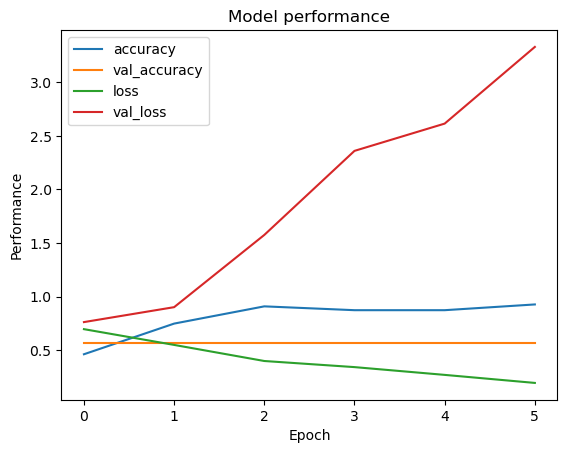

In [9]:
# Define CNN model for binary classification with dropout layers
model_dropout = Sequential([
    Input(shape=(256, 343, 1)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),  # Dropout layer with 25% dropout rate
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),  # Dropout layer with 25% dropout rate
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),  # Dropout layer with 25% dropout rate
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),  # Dropout layer with 50% dropout rate
    Dense(1, activation='sigmoid')  # Using sigmoid activation for binary classification
])

# Compile and train the model
model_dropout.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
callbacks = [EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)]
history = model_dropout.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1, callbacks=callbacks)

# Evaluate the model
test_loss, test_accuracy = model_dropout.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')
train_loss, train_accuracy = model_dropout.evaluate(X_train, y_train)
print(f'Train Loss: {train_loss}, Train Accuracy: {train_accuracy}')
# Train the model

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model performance')
plt.xlabel('Epoch')
plt.ylabel('Performance')
plt.legend()
plt.show()

## CNN binary epoch 16

Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 396ms/step - accuracy: 0.6589 - loss: 0.6603 - val_accuracy: 0.5714 - val_loss: 0.7502
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9402 - loss: 0.4776 - val_accuracy: 0.5714 - val_loss: 2.7198
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 364ms/step - accuracy: 0.9381 - loss: 0.2227 - val_accuracy: 0.5714 - val_loss: 5.4046
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 362ms/step - accuracy: 0.9515 - loss: 0.1323 - val_accuracy: 0.5714 - val_loss: 7.3797
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 362ms/step - accuracy: 0.9586 - loss: 0.1206 - val_accuracy: 0.5714 - val_loss: 6.5435
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 379ms/step - accuracy: 0.9824 - loss: 0.0676 - val_accuracy: 0.5714 - val_loss: 6.6598
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.7037 - loss: 0.6357
Test Loss: 0.6357262134552002, Test Accuracy: 0.7037037014961243
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.8945 - loss: 0.5586
Train Loss: 0.5674518346786499, T

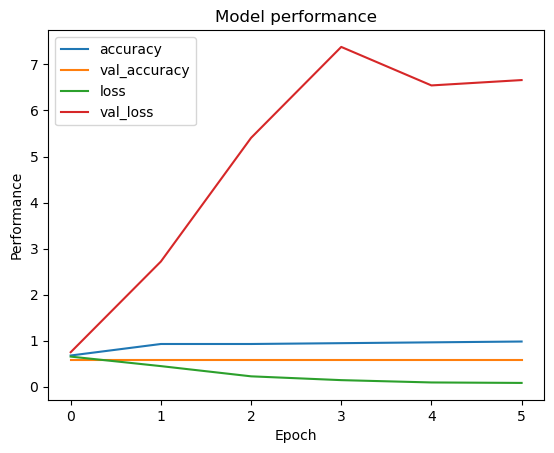

In [10]:
model_binary2 = Sequential([
    Input(shape=(256, 343, 1)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')  # Using sigmoid activation for binary classification
])

# Compile and train the model
model_binary2.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
callbacks = [EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)]
history = model_binary2.fit(X_train, y_train, epochs=20, batch_size=16, validation_split=0.1, callbacks=callbacks)

# Evaluate the model
test_loss, test_accuracy = model_binary2.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')
train_loss, train_accuracy = model_binary2.evaluate(X_train, y_train)
print(f'Train Loss: {train_loss}, Train Accuracy: {train_accuracy}')

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model performance')
plt.xlabel('Epoch')
plt.ylabel('Performance')
plt.legend()
plt.show()


Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 433ms/step - accuracy: 0.6054 - loss: 0.6802 - val_accuracy: 0.5714 - val_loss: 0.7323
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 400ms/step - accuracy: 0.6854 - loss: 0.5002 - val_accuracy: 0.5714 - val_loss: 1.0511
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 403ms/step - accuracy: 0.8545 - loss: 0.3267 - val_accuracy: 0.5714 - val_loss: 2.5604
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 395ms/step - accuracy: 0.9414 - loss: 0.1889 - val_accuracy: 0.5714 - val_loss: 2.6056
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 449ms/step - accuracy: 0.9298 - loss: 0.1992 - val_accuracy: 0.5714 - val_loss: 3.0130
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 408ms/step - accuracy: 0.9628 - loss: 0.1192 - val_accuracy: 0.5714 - val_loss: 4.4979
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 0.7407 - loss: 0.6062
Test Loss: 0.6061848998069763, Test Accuracy: 0.7407407164573669
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.7260 - loss: 0.5846
Train Loss: 0.5905337929725647, T

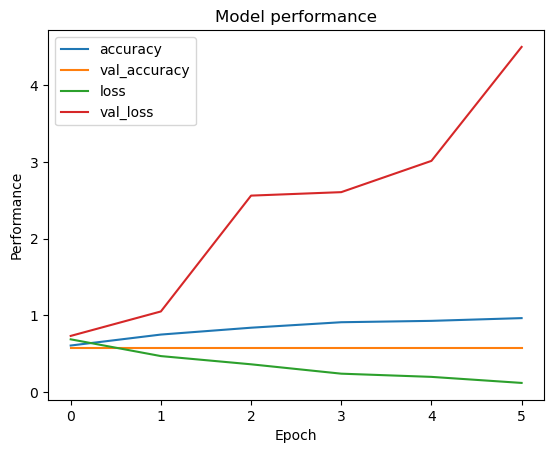

In [11]:
# Define CNN model for binary classification with dropout layers
model_dropout2 = Sequential([
    Input(shape=(256, 343, 1)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),  # Dropout layer with 25% dropout rate
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),  # Dropout layer with 25% dropout rate
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),  # Dropout layer with 25% dropout rate
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),  # Dropout layer with 50% dropout rate
    Dense(1, activation='sigmoid')  # Using sigmoid activation for binary classification
])

# Compile and train the model
model_dropout2.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
callbacks = [EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)]
history = model_dropout2.fit(X_train, y_train, epochs=20, batch_size=16, validation_split=0.1, callbacks=callbacks)

# Evaluate the model
test_loss, test_accuracy = model_dropout2.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')
train_loss, train_accuracy = model_dropout2.evaluate(X_train, y_train)
print(f'Train Loss: {train_loss}, Train Accuracy: {train_accuracy}')
# Train the model

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model performance')
plt.xlabel('Epoch')
plt.ylabel('Performance')
plt.legend()
plt.show()

Epoch 1/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 420ms/step - accuracy: 0.4506 - loss: 0.6522 - val_accuracy: 0.4286 - val_loss: 0.6852
Epoch 2/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 452ms/step - accuracy: 0.6646 - loss: 0.4476 - val_accuracy: 0.5714 - val_loss: 3.7013
Epoch 3/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 411ms/step - accuracy: 0.8988 - loss: 0.2325 - val_accuracy: 0.5714 - val_loss: 4.7041
Epoch 4/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 424ms/step - accuracy: 0.8810 - loss: 0.1960 - val_accuracy: 0.5714 - val_loss: 5.7771
Epoch 5/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 388ms/step - accuracy: 0.9711 - loss: 0.0879 - val_accuracy: 0.5714 - val_loss: 8.1364
Epoch 6/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 370ms/step - accuracy: 0.9711 - loss: 0.0926 - val_accuracy: 0.5714 - val_loss: 9.5484
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.6296 - loss: 0.5128
Test Loss: 0.5128135681152344, Test Accuracy: 0.6296296119689941
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.6629 - loss: 0.5269
Train Loss: 0.538045346736908, Tr

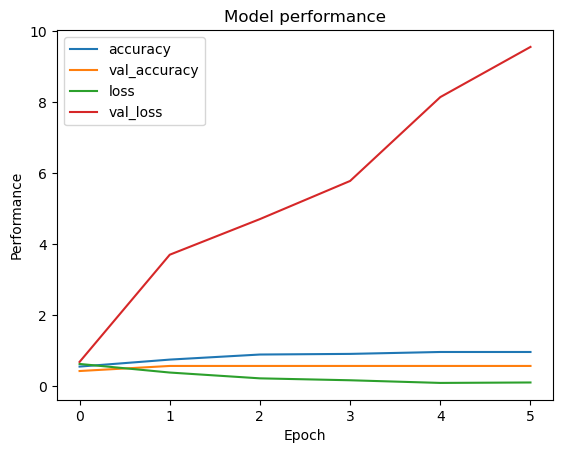

In [12]:
model_binary2 = Sequential([
    Input(shape=(256, 343, 1)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')  # Using sigmoid activation for binary classification
])

# Compile and train the model
model_binary2.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
callbacks = [EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)]
history = model_binary2.fit(X_train, y_train, epochs=30, batch_size=16, validation_split=0.1, callbacks=callbacks)

# Evaluate the model
test_loss, test_accuracy = model_binary2.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')
train_loss, train_accuracy = model_binary2.evaluate(X_train, y_train)
print(f'Train Loss: {train_loss}, Train Accuracy: {train_accuracy}')

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model performance')
plt.xlabel('Epoch')
plt.ylabel('Performance')
plt.legend()
plt.show()


Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 247ms/step - accuracy: 0.5649 - loss: 0.8181 - val_accuracy: 0.5714 - val_loss: 0.8102
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 230ms/step - accuracy: 0.8752 - loss: 0.4913 - val_accuracy: 0.5714 - val_loss: 2.7662
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 232ms/step - accuracy: 0.8714 - loss: 0.3117 - val_accuracy: 0.5714 - val_loss: 4.5243
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 230ms/step - accuracy: 0.9376 - loss: 0.1597 - val_accuracy: 0.4286 - val_loss: 3.9818
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 242ms/step - accuracy: 0.8881 - loss: 0.1683 - val_accuracy: 0.5714 - val_loss: 4.1172
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 232ms/step - accuracy: 0.9528 - loss: 0.1040 - val_accuracy: 0.5714 - val_loss: 3.7066
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - accuracy: 0.5185 - loss: 0.6668
Test Loss: 0.6667750477790833, Test Accuracy: 0.5185185074806213
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.8525 - loss: 0.5583
Train Loss: 0.5696545243263245, T

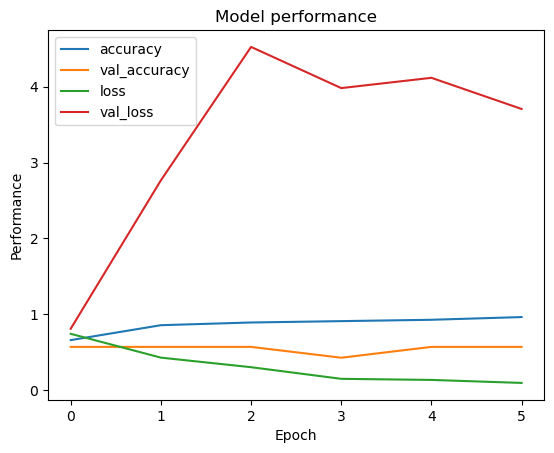

In [13]:
model_binary2 = Sequential([
    Input(shape=(256, 343, 1)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')  # Using sigmoid activation for binary classification
])

# Compile and train the model
model_binary2.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
callbacks = [EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)]
history = model_binary2.fit(X_train, y_train, epochs=20, batch_size=8, validation_split=0.1, callbacks=callbacks)

# Evaluate the model
test_loss, test_accuracy = model_binary2.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')
train_loss, train_accuracy = model_binary2.evaluate(X_train, y_train)
print(f'Train Loss: {train_loss}, Train Accuracy: {train_accuracy}')

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model performance')
plt.xlabel('Epoch')
plt.ylabel('Performance')
plt.legend()
plt.show()


## Binary RNN 

In [14]:
# Reshape the data for RNN input (samples, time steps, features)
X_train_rnn = X_train.reshape((X_train.shape[0], 343, 256))
X_test_rnn = X_test.reshape((X_test.shape[0], 343, 256))

# Define RNN model for binary classification
model_rnn = Sequential([
    Input(shape=(343, 256)),
    LSTM(64, return_sequences=True),
    LSTM(64),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')  # Using sigmoid activation for binary classification
])

# Compile and train the model
model_rnn.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
callbacks = [EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)]


Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 276ms/step - accuracy: 0.5952 - loss: 0.6921 - val_accuracy: 0.5714 - val_loss: 0.6910
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.7842 - loss: 0.6851 - val_accuracy: 0.5714 - val_loss: 0.6864
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.8259 - loss: 0.6740 - val_accuracy: 0.5714 - val_loss: 0.6780
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.7961 - loss: 0.6601 - val_accuracy: 0.5714 - val_loss: 0.6595
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.8065 - loss: 0.6362 - val_accuracy: 0.5714 - val_loss: 0.6340
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.7946 - loss: 0.5940 - val_accuracy: 0.5714 - val_loss: 0.6122
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.7738 - loss: 0.5644 - val_accuracy: 0.5714 - val_loss: 0.6255
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.7827 - loss: 0.5032 - val_accuracy: 0.5714 - val_loss:

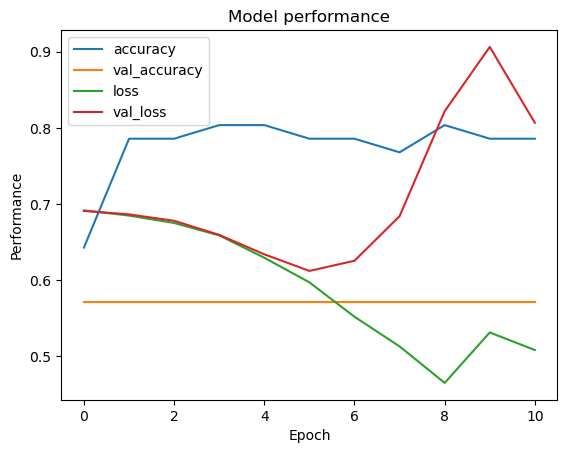

CPU times: user 6.04 s, sys: 930 ms, total: 6.97 s
Wall time: 4.73 s


In [15]:
%%time
history = model_rnn.fit(X_train_rnn, y_train, epochs=20, batch_size=32, validation_split=0.1, callbacks=callbacks)

# Evaluate the model
test_loss, test_accuracy = model_rnn.evaluate(X_test_rnn, y_test)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')
train_loss, train_accuracy = model_rnn.evaluate(X_train_rnn, y_train)
print(f'Train Loss: {train_loss}, Train Accuracy: {train_accuracy}')

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model performance')
plt.xlabel('Epoch')
plt.ylabel('Performance')
plt.legend()
plt.show()


In [16]:
model_rnn2 = Sequential([
    Input(shape=(343, 256)),
    LSTM(64, return_sequences=True),
    LSTM(64),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')  # Using sigmoid activation for binary classification
])

# Compile and train the model
model_rnn2.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
callbacks = [EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)]


Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 152ms/step - accuracy: 0.7262 - loss: 0.6913 - val_accuracy: 0.5714 - val_loss: 0.6869
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.7798 - loss: 0.6753 - val_accuracy: 0.5714 - val_loss: 0.6612
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.7509 - loss: 0.6357 - val_accuracy: 0.5714 - val_loss: 0.6084
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.7563 - loss: 0.5699 - val_accuracy: 0.5714 - val_loss: 0.6474
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.7643 - loss: 0.5008 - val_accuracy: 0.5714 - val_loss: 0.8920
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.7860 - loss: 0.5173 - val_accuracy: 0.5714 - val_loss: 0.9173
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.7634 - loss: 0.5155 - val_accuracy: 0.5714 - val_loss: 0.7771
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.8018 - loss: 0.4503 - val_accuracy: 0.5714 - val_loss:

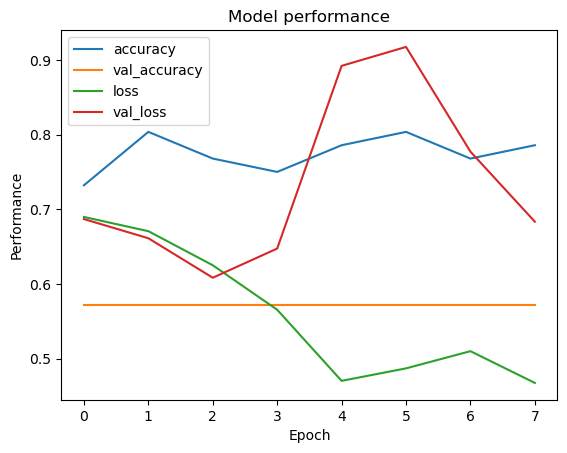

In [17]:
history = model_rnn2.fit(X_train_rnn, y_train, epochs=20, batch_size=16, validation_split=0.1, callbacks=callbacks)

# Evaluate the model
test_loss, test_accuracy = model_rnn2.evaluate(X_test_rnn, y_test)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')
train_loss, train_accuracy = model_rnn2.evaluate(X_train_rnn, y_train)
print(f'Train Loss: {train_loss}, Train Accuracy: {train_accuracy}')

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model performance')
plt.xlabel('Epoch')
plt.ylabel('Performance')
plt.legend()
plt.show()


## Multi Class Model

In [18]:
with h5py.File('spectrograms.h5', 'r') as f:
    species_names = list(f.keys())
    for species_name in species_names:
        species_data = f[species_name][...]
        print(f'Species: {species_name}, Shape: {species_data.shape}')

Species: amecro, Shape: (256, 343, 52)
Species: barswa, Shape: (256, 343, 55)
Species: bkcchi, Shape: (256, 343, 57)
Species: blujay, Shape: (256, 343, 50)
Species: daejun, Shape: (256, 343, 58)
Species: houfin, Shape: (256, 343, 44)
Species: mallar3, Shape: (256, 343, 36)
Species: norfli, Shape: (256, 343, 59)
Species: rewbla, Shape: (256, 343, 41)
Species: stejay, Shape: (256, 343, 40)
Species: wesmea, Shape: (256, 343, 36)
Species: whcspa, Shape: (256, 343, 51)


In [19]:
import numpy as np
import h5py
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

# Load the data
def load_and_preprocess_data(hdf5_file):
    features = []
    labels = []
    
    # Assign each species a unique label
    species_keys = list(hdf5_file.keys())
    species_labels = {species: idx for idx, species in enumerate(species_keys)}
    
    # Populate the features and labels with data from all species
    for species, label in species_labels.items():
        data_species = hdf5_file[species][:]
        features.extend([data_species[:, :, i] for i in range(data_species.shape[2])])
        labels.extend([label] * data_species.shape[2])
    
    # Convert features and labels to numpy arrays
    features = np.array(features)
    labels = np.array(labels)
    
    # Normalize the features
    features = features / np.max(features)
    
    # Reshape features to add the channel dimension (e.g., grayscale images have 1 channel)
    features = features[..., np.newaxis]
    
    return features, labels, species_labels

# Load and preprocess the data
with h5py.File('spectrograms.h5', 'r') as f:
    features, labels, species_labels = load_and_preprocess_data(f)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=123)

# Convert labels to one-hot encoding
y_train_one_hot = to_categorical(y_train, num_classes=len(species_labels))
y_test_one_hot = to_categorical(y_test, num_classes=len(species_labels))

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train_one_hot.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test_one_hot.shape)


X_train shape: (405, 256, 343, 1)
y_train shape: (405, 12)
X_test shape: (174, 256, 343, 1)
y_test shape: (174, 12)


In [20]:
# Define the CNN model
model_multi = Sequential([
    Input(shape=(256, 343, 1)),
    Conv2D(32, (3, 3), activation='relu', padding='same'),   
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(len(species_labels), activation='softmax')
])

# Compile the model
model_multi.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Early stopping to prevent overfitting
callbacks = [EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)]

# Train the model
history = model_multi.fit(X_train, y_train_one_hot, epochs=20, batch_size=32, validation_split=0.1, callbacks=callbacks)

# Evaluate the model
test_loss, test_accuracy = model_multi.evaluate(X_test, y_test_one_hot)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')


Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 856ms/step - accuracy: 0.2441 - loss: 2.2549 - val_accuracy: 0.4146 - val_loss: 1.8142
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 903ms/step - accuracy: 0.6809 - loss: 1.2642 - val_accuracy: 0.4146 - val_loss: 2.6820
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 850ms/step - accuracy: 0.8247 - loss: 0.5066 - val_accuracy: 0.6341 - val_loss: 2.0106
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 847ms/step - accuracy: 0.9282 - loss: 0.2511 - val_accuracy: 0.5854 - val_loss: 2.5761
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 849ms/step - accuracy: 0.9295 - loss: 0.2518 - val_accuracy: 0.6341 - val_loss: 2.5906
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 850ms/step - accuracy: 0.9643 - loss: 0.1422 - val_accuracy: 0.6341 - val_loss: 2.9841
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 219ms/step - accuracy: 0.4950 - loss: 1.6706
Test Loss: 1.6973307132720947, Test Accuracy: 0.4655172526836395


In [21]:
train_loss, train_accuracy = model_multi.evaluate(X_train, y_train_one_hot)
print(f'Train Loss: {train_loss}, Train Accuracy: {train_accuracy}')

13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 234ms/step - accuracy: 0.6652 - loss: 1.3971
Train Loss: 1.434955358505249, Train Accuracy: 0.6419752836227417


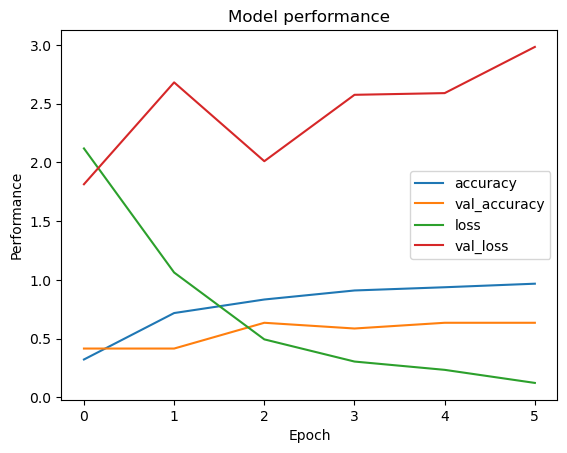

In [22]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model performance')
plt.xlabel('Epoch')
plt.ylabel('Performance')
plt.legend()
plt.show()

In [23]:
print(species_labels)

{'amecro': 0, 'barswa': 1, 'bkcchi': 2, 'blujay': 3, 'daejun': 4, 'houfin': 5, 'mallar3': 6, 'norfli': 7, 'rewbla': 8, 'stejay': 9, 'wesmea': 10, 'whcspa': 11}


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 233ms/step


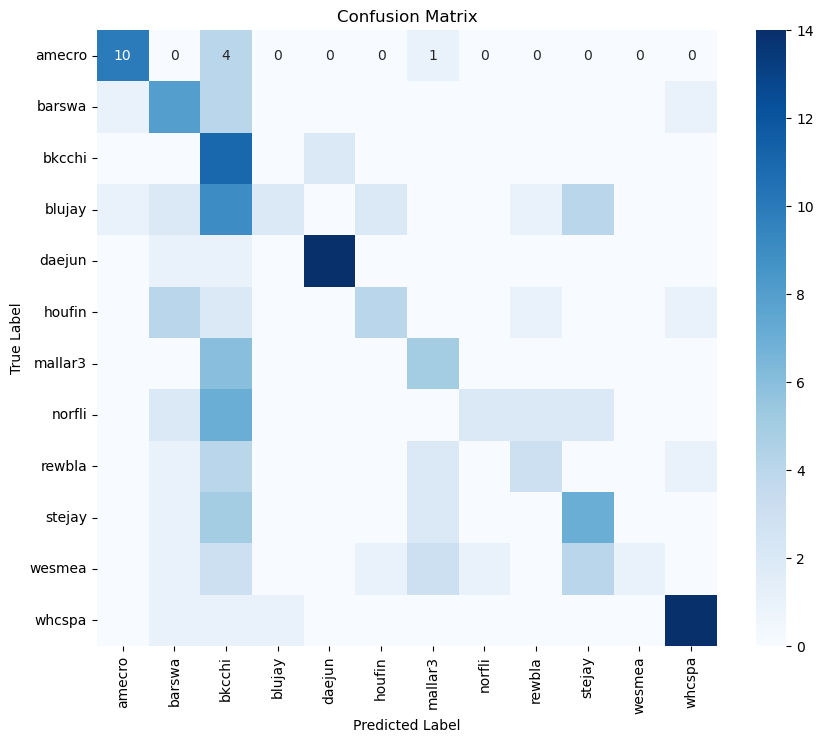

In [24]:

# Assuming y_test_one_hot was created earlier
# If y_test is not one-hot encoded, ensure to convert it correctly
# Make predictions
y_pred = model_multi.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert one-hot encoded labels to integers for the test set
y_test_classes = np.argmax(y_test_one_hot, axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)

# Ensure species labels are sorted correctly by their integer label
sorted_species_keys = [species for species, idx in sorted(species_labels.items(), key=lambda item: item[1])]

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=sorted_species_keys, yticklabels=sorted_species_keys)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 880ms/step - accuracy: 0.2735 - loss: 2.2312 - val_accuracy: 0.4390 - val_loss: 1.8244
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 839ms/step - accuracy: 0.7080 - loss: 1.0766 - val_accuracy: 0.4878 - val_loss: 2.5851
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 812ms/step - accuracy: 0.7900 - loss: 0.5990 - val_accuracy: 0.4390 - val_loss: 1.9254
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 806ms/step - accuracy: 0.9146 - loss: 0.3219 - val_accuracy: 0.4390 - val_loss: 2.6402
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 815ms/step - accuracy: 0.9210 - loss: 0.2528 - val_accuracy: 0.5854 - val_loss: 3.6730
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 813ms/step - accuracy: 0.9289 - loss: 0.2629 - val_accuracy: 0.5610 - val_loss: 4.3137
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 198ms/step - accuracy: 0.5425 - loss: 1.5943
Test Loss: 1.6611186265945435, Test Accuracy: 0.522988498210907
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 239ms/step - accuracy: 0.6625 - loss: 1.2181
Train Loss: 1.

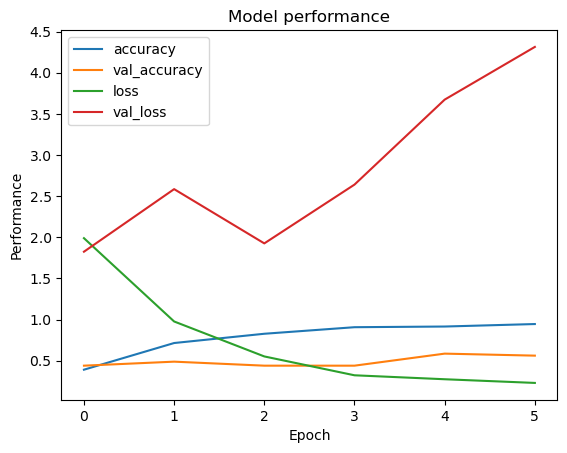

In [25]:
# Define the CNN model
model_multi_no = Sequential([
    Input(shape=(256, 343, 1)),
    Conv2D(32, (3, 3), activation='relu'),   
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(len(species_labels), activation='softmax')
])

# Compile the model
model_multi_no.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Early stopping to prevent overfitting
callbacks = [EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)]

# Train the model
history = model_multi_no.fit(X_train, y_train_one_hot, epochs=20, batch_size=32, validation_split=0.1, callbacks=callbacks)

# Evaluate the model
test_loss, test_accuracy = model_multi_no.evaluate(X_test, y_test_one_hot)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')
train_loss, train_accuracy = model_multi_no.evaluate(X_train, y_train_one_hot)
print(f'Train Loss: {train_loss}, Train Accuracy: {train_accuracy}')
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model performance')
plt.xlabel('Epoch')
plt.ylabel('Performance')
plt.legend()
plt.show()



## Best multi model

In [26]:
model_multi3 = Sequential([
    Input(shape=(256, 343, 1)),
    Conv2D(32, (3, 3), activation='relu'),   
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(len(species_labels), activation='softmax')
])

# Compile the model
model_multi3.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Early stopping to prevent overfitting
callbacks = [EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)]

# Train the model
history = model_multi3.fit(X_train, y_train_one_hot, epochs=20, batch_size=16, validation_split=0.1, callbacks=callbacks)

# Evaluate the model
test_loss, test_accuracy = model_multi3.evaluate(X_test, y_test_one_hot)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')


Epoch 1/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 12s 481ms/step - accuracy: 0.3274 - loss: 2.1978 - val_accuracy: 0.4390 - val_loss: 2.2946
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 477ms/step - accuracy: 0.7755 - loss: 0.7882 - val_accuracy: 0.5366 - val_loss: 1.8885
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 477ms/step - accuracy: 0.8925 - loss: 0.3510 - val_accuracy: 0.5854 - val_loss: 2.3699
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 435ms/step - accuracy: 0.9107 - loss: 0.3068 - val_accuracy: 0.5610 - val_loss: 2.1739
Epoch 5/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 438ms/step - accuracy: 0.9552 - loss: 0.1559 - val_accuracy: 0.5366 - val_loss: 4.0838
Epoch 6/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 454ms/step - accuracy: 0.9722 - loss: 0.0799 - val_accuracy: 0.5366 - val_loss: 5.7490
Epoch 7/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 486ms/step - accuracy: 0.9839 - loss: 0.0805 - val_accuracy: 0.4390 - val_loss: 7.6641
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 214ms/step - accuracy: 0.5736 - loss: 1.2796
Test Loss: 1.40299403667

In [27]:
train_loss, train_accuracy = model_multi3.evaluate(X_train, y_train_one_hot)
print(f'Train Loss: {train_loss}, Train Accuracy: {train_accuracy}')
model_multi3.save('cnn_multi_model3.keras')

13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 220ms/step - accuracy: 0.9041 - loss: 0.3724
Train Loss: 0.5149322748184204, Train Accuracy: 0.8641975522041321


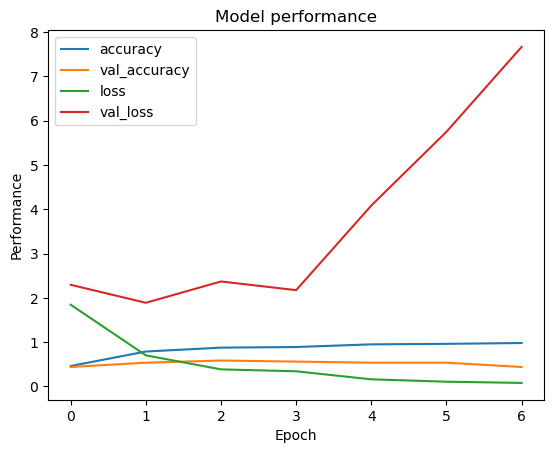

In [28]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model performance')
plt.xlabel('Epoch')
plt.ylabel('Performance')
plt.legend()
plt.show()

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 209ms/step


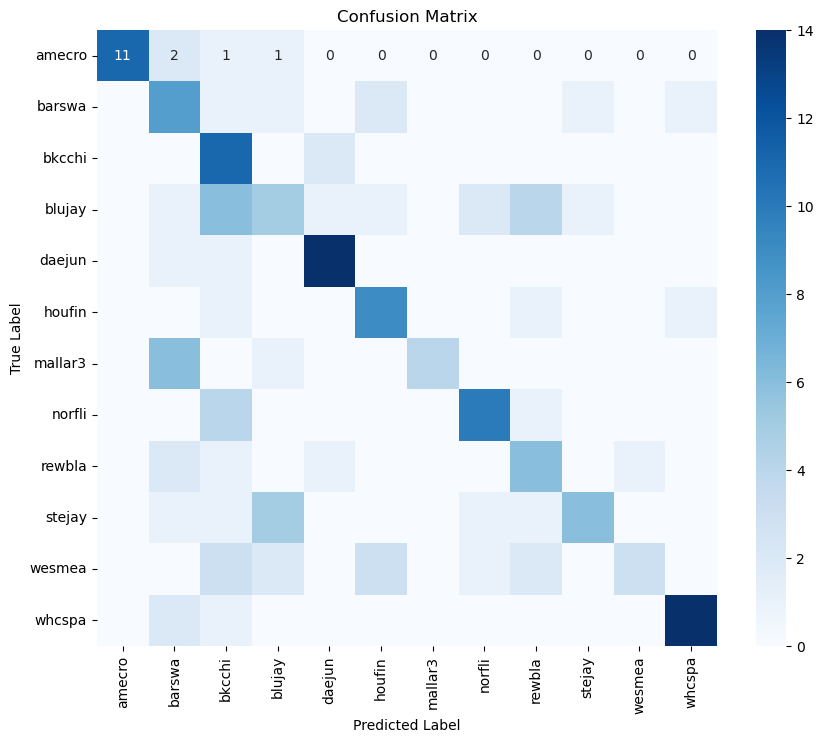

In [29]:
y_pred = model_multi3.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert one-hot encoded labels to integers for the test set
y_test_classes = np.argmax(y_test_one_hot, axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)

# Ensure species labels are sorted correctly by their integer label
sorted_species_keys = [species for species, idx in sorted(species_labels.items(), key=lambda item: item[1])]

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=sorted_species_keys, yticklabels=sorted_species_keys)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [30]:
X_train.shape

(405, 256, 343, 1)

## External data test 

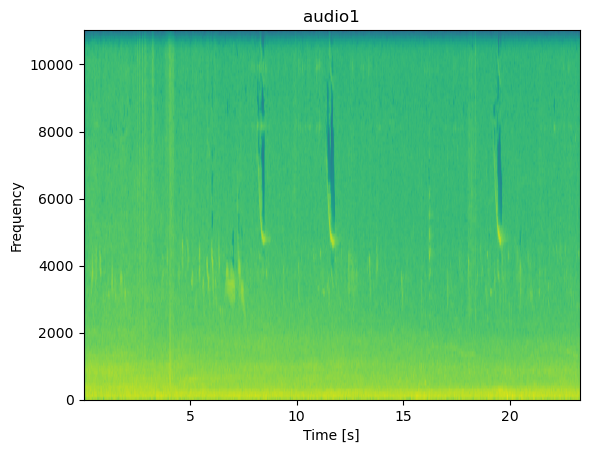

/opt/anaconda3/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7939: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


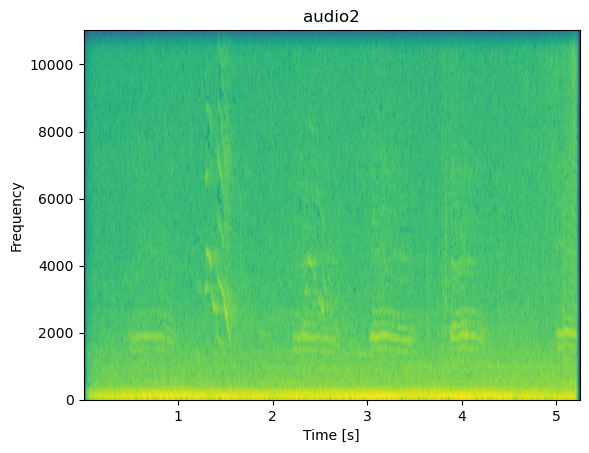

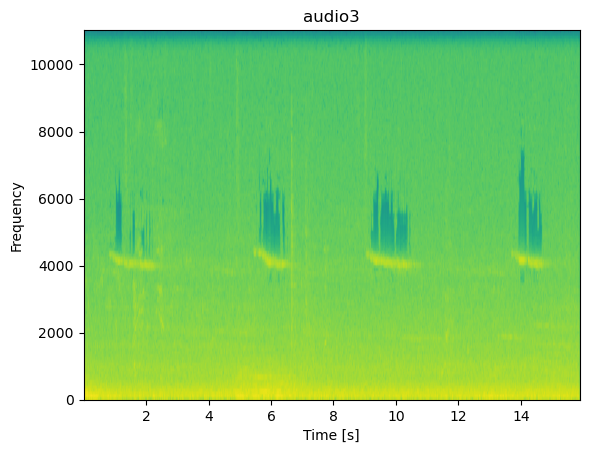

In [31]:
import librosa
import matplotlib.pyplot as plt

def plot_spectrogram(audio_path, title):
    # Load audio file
    wave, rate = librosa.load(audio_path)

    # Plot spectrogram
    plt.specgram(wave, Fs=rate)
    plt.xlabel("Time [s]")
    plt.ylabel("Frequency")
    plt.title(title)
    plt.show()

# Paths to the three audio files
audio_paths = [
    "/Users/zahra/Library/CloudStorage/OneDrive-SeattleUniversity/spring2024/ML2/Deep Learning/test_birds/test1.mp3",
    "/Users/zahra/Library/CloudStorage/OneDrive-SeattleUniversity/spring2024/ML2/Deep Learning/test_birds/test2.mp3",
    "/Users/zahra/Library/CloudStorage/OneDrive-SeattleUniversity/spring2024/ML2/Deep Learning/test_birds/test3.mp3"
]

# Titles for the spectrograms
titles = ["audio1", "audio2", "audio3"]

# Plot spectrogram for each audio file
for audio_path, title in zip(audio_paths, titles):
    plot_spectrogram(audio_path, title)


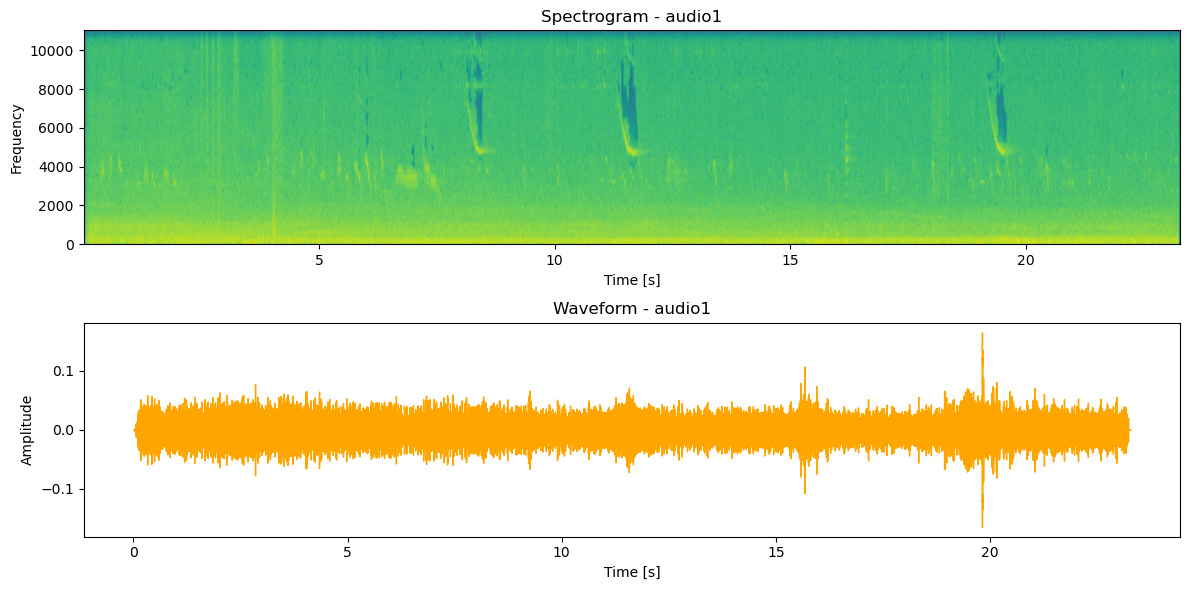

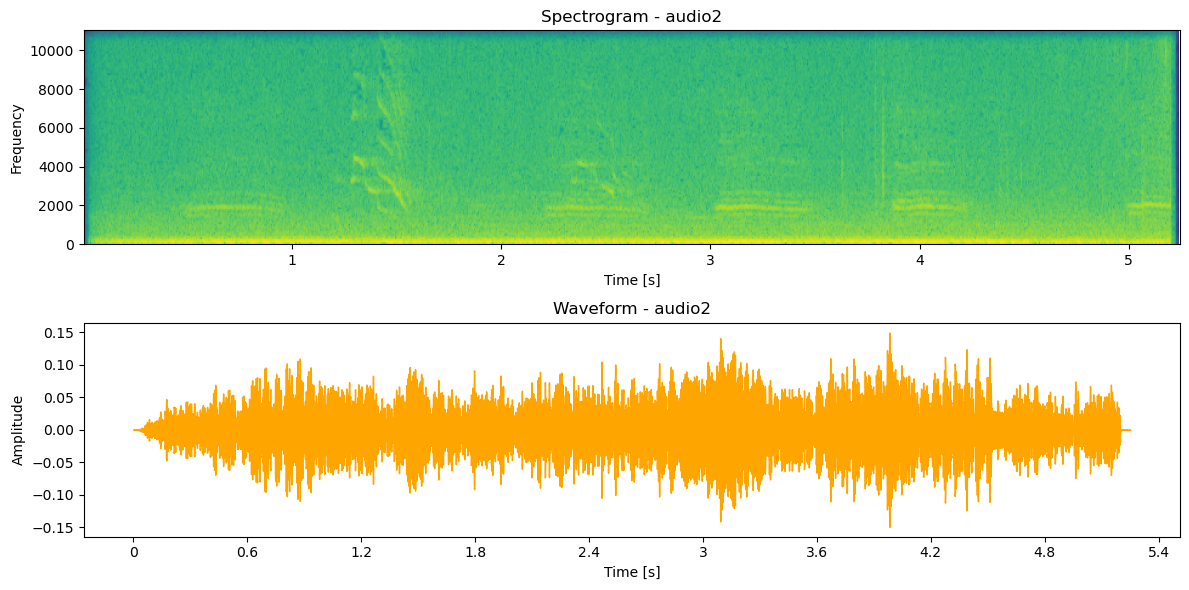

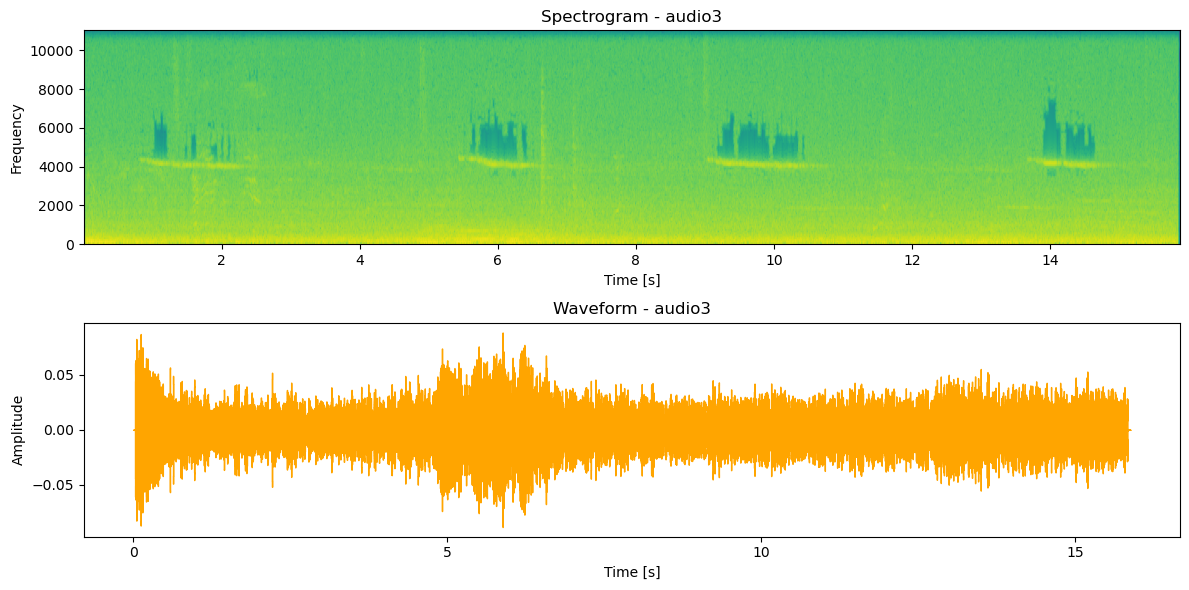

In [32]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

def plot_spectrogram_and_waveform(audio_path, title):
    # Load audio file
    data, rate = librosa.load(audio_path)

    # Plot spectrogram
    plt.figure(figsize=(12, 6))
    plt.subplot(2, 1, 1)
    plt.specgram(data, Fs=rate)
    plt.xlabel("Time [s]")
    plt.ylabel("Frequency")
    plt.title(f'Spectrogram - {title}')

    # Plot waveform
    plt.subplot(2, 1, 2)
    librosa.display.waveshow(data, sr=rate, color='orange')
    plt.xlabel("Time [s]")
    plt.ylabel("Amplitude")
    plt.title(f'Waveform - {title}')

    plt.tight_layout()
    plt.show()

# Paths to the three audio files
audio_paths = [
    "/Users/zahra/Library/CloudStorage/OneDrive-SeattleUniversity/spring2024/ML2/Deep Learning/test_birds/test1.mp3",
    "/Users/zahra/Library/CloudStorage/OneDrive-SeattleUniversity/spring2024/ML2/Deep Learning/test_birds/test2.mp3",
    "/Users/zahra/Library/CloudStorage/OneDrive-SeattleUniversity/spring2024/ML2/Deep Learning/test_birds/test3.mp3"
]

# Titles for the plots
titles = ["audio1", "audio2", "audio3"]

# Plot spectrogram and waveform for each audio file
for audio_path, title in zip(audio_paths, titles):
    plot_spectrogram_and_waveform(audio_path, title)


In [33]:
import librosa
import numpy as np
import os
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam

def create_spectrogram(audio_file_path, new_sample_rate=22050, min_loud_part_length=0.5, bird_call_window_size=2,
                       n_fft=2048, hop_length=512):
    y, sr = librosa.load(audio_file_path, sr=new_sample_rate)
    energy = librosa.feature.rms(y=y, frame_length=n_fft, hop_length=hop_length)
    loud_parts = librosa.effects.split(y, top_db=20)
    
    spectrograms = []
    labels = []

    for start, end in loud_parts:
        segment_duration = (end - start) / sr
        if segment_duration > min_loud_part_length:
            for i in range(start, end, hop_length):
                bird_call_audio = y[i:i + int(bird_call_window_size * sr)]
                if len(bird_call_audio) == int(bird_call_window_size * sr):
                    spectrogram = librosa.feature.melspectrogram(y=bird_call_audio, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=256, fmax=8000)
                    
                    if spectrogram.shape[1] < 343:
                        padding = np.zeros((256, 343 - spectrogram.shape[1]))
                        spectrogram = np.hstack((spectrogram, padding))
                    elif spectrogram.shape[1] > 343:
                        spectrogram = spectrogram[:, :343]

                    spectrogram = spectrogram[:, :, np.newaxis]
                    
                    spectrograms.append(spectrogram)
                    labels.append(os.path.splitext(os.path.basename(audio_file_path))[0])
                    
    return spectrograms, labels

folder_path = 'test_birds'

all_spectrograms = []
all_labels = []

for audio_file in os.listdir(folder_path):
    if audio_file.endswith('.mp3'): 
        audio_file_path = os.path.join(folder_path, audio_file)
        spectrograms, labels = create_spectrogram(audio_file_path)
        all_spectrograms.extend(spectrograms)
        all_labels.extend(labels)

all_spectrograms = np.array(all_spectrograms)
all_labels = np.array(all_labels)
print(all_labels.shape)
print(all_spectrograms.shape)

model_path = 'cnn_multi_model2.keras'  # Update with the path to your saved model
model = load_model(model_path)

model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
predictions = model.predict(all_spectrograms)

class_to_species = {
    0: 'amecro', 1: 'barswa', 2: 'bkcchi', 3: 'blujay', 4: 'daejun', 5: 'houfin', 
    6: 'mallar3', 7: 'norfli', 8: 'rewbla', 9: 'stejay', 10: 'wesmea', 11: 'whcspa'
}

file_names = [file.split('.')[0] for file in os.listdir(folder_path) if file.endswith('.mp3')]

# Aggregate predictions for each audio file
file_to_predictions = {file_name: [] for file_name in file_names}

for idx, (pred, label) in enumerate(zip(predictions, all_labels)):
    file_to_predictions[label].append(pred)

# Display the top five predictions for each test set
for file_name, species_probs_list in file_to_predictions.items():
    aggregated_probs = np.mean(species_probs_list, axis=0)  # Aggregate the predictions for the file
    print("Original Label:", file_name)
    sorted_indices = np.argsort(aggregated_probs)[::-1][:5]
    for i, index in enumerate(sorted_indices):
        species = class_to_species[index]
        probability = aggregated_probs[index]
        print(f"Top {i+1} Predicted Bird Species: {species} - Class: {index} - Probability: {probability:.4f}")
    print()


(1648,)
(1648, 256, 343, 1)
52/52 ━━━━━━━━━━━━━━━━━━━━ 12s 230ms/step
Original Label: test3
Top 1 Predicted Bird Species: blujay - Class: 3 - Probability: 0.5179
Top 2 Predicted Bird Species: wesmea - Class: 10 - Probability: 0.2317
Top 3 Predicted Bird Species: barswa - Class: 1 - Probability: 0.1224
Top 4 Predicted Bird Species: norfli - Class: 7 - Probability: 0.0535
Top 5 Predicted Bird Species: mallar3 - Class: 6 - Probability: 0.0253

Original Label: test2
Top 1 Predicted Bird Species: wesmea - Class: 10 - Probability: 0.9036
Top 2 Predicted Bird Species: norfli - Class: 7 - Probability: 0.0852
Top 3 Predicted Bird Species: blujay - Class: 3 - Probability: 0.0112
Top 4 Predicted Bird Species: mallar3 - Class: 6 - Probability: 0.0000
Top 5 Predicted Bird Species: bkcchi - Class: 2 - Probability: 0.0000

Original Label: test1
Top 1 Predicted Bird Species: blujay - Class: 3 - Probability: 0.5420
Top 2 Predicted Bird Species: wesmea - Class: 10 - Probability: 0.2922
Top 3 Predicted B

In [34]:
def create_spectrogram(audio_file_path, new_sample_rate=22050, min_loud_part_length=0.5, bird_call_window_size=2,
                       n_fft=2048, hop_length=512):
    y, sr = librosa.load(audio_file_path, sr=new_sample_rate)
    energy = librosa.feature.rms(y=y, frame_length=n_fft, hop_length=hop_length)
    loud_parts = librosa.effects.split(y, top_db=20)
    
    spectrograms = []
    labels = []

    for start, end in loud_parts:
        segment_duration = (end - start) / sr
        if segment_duration > min_loud_part_length:
            for i in range(start, end, hop_length):
                bird_call_audio = y[i:i + int(bird_call_window_size * sr)]
                if len(bird_call_audio) == int(bird_call_window_size * sr):
                    spectrogram = librosa.feature.melspectrogram(y=bird_call_audio, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=256, fmax=8000)
                    
                    if spectrogram.shape[1] < 343:
                        padding = np.zeros((256, 343 - spectrogram.shape[1]))
                        spectrogram = np.hstack((spectrogram, padding))
                    elif spectrogram.shape[1] > 343:
                        spectrogram = spectrogram[:, :343]

                    spectrogram = spectrogram[:, :, np.newaxis]
                    
                    spectrograms.append(spectrogram)
                    labels.append(os.path.splitext(os.path.basename(audio_file_path))[0])
                    
    return spectrograms, labels

folder_path = 'test_birds'

all_spectrograms = []
all_labels = []

for audio_file in os.listdir(folder_path):
    if audio_file.endswith('.mp3'): 
        audio_file_path = os.path.join(folder_path, audio_file)
        spectrograms, labels = create_spectrogram(audio_file_path)
        all_spectrograms.extend(spectrograms)
        all_labels.extend(labels)

all_spectrograms = np.array(all_spectrograms)
all_labels = np.array(all_labels)
print(all_labels.shape)
print(all_spectrograms.shape)

model_path2 = 'cnn_multi_model3.keras'  # Update with the path to your saved model
model2 = load_model(model_path2)

model2.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
predictions = model2.predict(all_spectrograms)

class_to_species = {
    0: 'amecro', 1: 'barswa', 2: 'bkcchi', 3: 'blujay', 4: 'daejun', 5: 'houfin', 
    6: 'mallar3', 7: 'norfli', 8: 'rewbla', 9: 'stejay', 10: 'wesmea', 11: 'whcspa'
}

file_names = [file.split('.')[0] for file in os.listdir(folder_path) if file.endswith('.mp3')]

# Aggregate predictions for each audio file
file_to_predictions = {file_name: [] for file_name in file_names}

for idx, (pred, label) in enumerate(zip(predictions, all_labels)):
    file_to_predictions[label].append(pred)

# Display the top five predictions for each test set
for file_name, species_probs_list in file_to_predictions.items():
    aggregated_probs = np.mean(species_probs_list, axis=0)  # Aggregate the predictions for the file
    print("Original Label:", file_name)
    sorted_indices = np.argsort(aggregated_probs)[::-1][:5]
    for i, index in enumerate(sorted_indices):
        species = class_to_species[index]
        probability = aggregated_probs[index]
        print(f"Top {i+1} Predicted Bird Species: {species} - Class: {index} - Probability: {probability:.4f}")
    print()

(1648,)
(1648, 256, 343, 1)
52/52 ━━━━━━━━━━━━━━━━━━━━ 12s 238ms/step
Original Label: test3
Top 1 Predicted Bird Species: blujay - Class: 3 - Probability: 0.5180
Top 2 Predicted Bird Species: wesmea - Class: 10 - Probability: 0.4358
Top 3 Predicted Bird Species: barswa - Class: 1 - Probability: 0.0321
Top 4 Predicted Bird Species: stejay - Class: 9 - Probability: 0.0092
Top 5 Predicted Bird Species: norfli - Class: 7 - Probability: 0.0021

Original Label: test2
Top 1 Predicted Bird Species: norfli - Class: 7 - Probability: 0.5266
Top 2 Predicted Bird Species: blujay - Class: 3 - Probability: 0.3267
Top 3 Predicted Bird Species: wesmea - Class: 10 - Probability: 0.1459
Top 4 Predicted Bird Species: stejay - Class: 9 - Probability: 0.0008
Top 5 Predicted Bird Species: barswa - Class: 1 - Probability: 0.0000

Original Label: test1
Top 1 Predicted Bird Species: blujay - Class: 3 - Probability: 0.5478
Top 2 Predicted Bird Species: wesmea - Class: 10 - Probability: 0.4252
Top 3 Predicted Bir